In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTEENN, SMOTETomek  
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, 
                             precision_recall_curve, ConfusionMatrixDisplay, RocCurveDisplay, matthews_corrcoef, make_scorer)
from nltk.util import bigrams
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline, pad_both_ends

In [ ]:
shap.initjs()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/preprocess.csv" "bot.csv"

In [ ]:
dfs = []
dfs = pd.read_csv("bot.csv")
dfs = dfs.replace([np.inf, -np.inf], np.nan)
dfs = dfs.replace(np.nan, 0)
dfs = dfs.drop_duplicates(subset=['id'])
dfs

In [ ]:
dfs['screen_name'] = dfs['screen_name'].str.rstrip() #For calculating Yang et al Features for baseline
TwitH = dfs['screen_name']
train, vocab = padded_everygram_pipeline(2, TwitH)
lm = MLE(2)
lm.fit(train, vocab)
Twit = dfs
Twit['screen_name_num']= dfs['screen_name'].str.count('\d') #count of numbers in screename
Twit['screen_name_length'] = dfs['screen_name'].str.len() #len of screen name
Twit['name_length'] = dfs['name'].str.len() #len of name
Twit['name_num']= dfs['name'].str.count('\d') #count of numbers in name
Twit['description_len'] = dfs['description'].str.len()#len of description
Twit['screen_perp'] = dfs['screen_name'].map(lambda x : lm.perplexity(bigrams(pad_both_ends(x, n=2))))
Twit['tweet_rate'] = (dfs['status_count']/dfs['Account_age'])
Twit['friend_rate'] = (dfs['friends_count']/dfs['Account_age'])
Twit['following_rate'] = (dfs['followers_count']/dfs['Account_age'])
Twit['favorites_rate'] = (dfs['favorites_count']/dfs['Account_age'])
Twit['listed_rate'] = (dfs['listed_count']/dfs['Account_age'])
Twit= Twit.drop(columns=['is_bot', 'Data','id','Account_age','frequ_minutes_tweet','favorites_per_tweet', 'profile_use_background_image',	'default_profile',	'description',	'screen_name',	'name','num_hashtags',	'num_urls',	'num_mentions',	'retweet_count',	'subjectivity_score',	'compound',	'neg',	'neu','pos',	'Text_sim'],axis=1)
Twit = Twit.replace([np.inf, -np.inf], np.nan)
Twit = Twit.replace(np.nan, 0) #for the cases where screen likelihood is infinity in test set for unseen examples

Yang et al Features

In [ ]:
y = dfs['is_bot']
data = dfs.drop(columns=['is_bot', 'Data','id','Account_age','frequ_minutes_tweet','favorites_per_tweet', 'profile_use_background_image',	'default_profile',	'description',	'screen_name',	'name'],axis=1)
x = data
dfs.isnull().values.any()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=12)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
x_train.columns=data.columns #change to Twit when testing yang features
x_test.columns=data.columns

In [ ]:
dfs.boxplot(column=['num_urls'], by="is_bot",figsize=(8,6))

In [ ]:
class_H = dfs[dfs['is_bot'] == 0]
class_SS = dfs[dfs['is_bot'] == 1]
data1 = class_H['compound']
data2 = class_SS['compound']
plt.figure(figsize=(8,6))
plt.hist(data1, bins=5, alpha=0.5, label="Human")
plt.hist(data2, bins=5, alpha=0.5, label="Bot")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Comparison of url ratio of Bots and Humans")
plt.legend(loc='upper right')

In [ ]:
lr_param = {
    'C': [0.1, 1, 10, 100, 1000]
}

SVM_param = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear','sigmoid']
}

rf_param = {
    'n_estimators': [100,150,200],
    'criterion' :['entropy','log_loss'],
    'max_depth' : [2,4,6],
    'max_features': ['sqrt', 'log2'],
    'bootstrap' : [ True, False]
}

xgb_param = {
    'min_child_weight': [5, 10, 15],
    'gamma': [0.1,0.5, 1],
    'subsample': [0.6, 1.0],
    'max_depth': [3, 4, 5,6]
}

In [ ]:
grid1 = model_selection.GridSearchCV(LogisticRegression(penalty='l2',class_weight='balanced') , param_grid=lr_param , scoring='precision',cv=5)
grid1.fit(x_train, y_train)
best_model1 = grid1.best_estimator_
best_model1.fit(x_train, y_train)

In [ ]:
y_pred1 = best_model1.predict(x_test)
clf = classification_report(y_pred1, y_test)
print(clf)

In [ ]:
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred1)) #Print the Matthew Correlation coefficient for Model 1
print('\nf1:',f1_score(y_test, y_pred1)) #Print the F1 score for Model 1
print('\nprecision:',precision_score(y_test, y_pred1)) #Print the Precision for Model 1
print('\nrecall:',recall_score(y_test, y_pred1)) #Print the Recall value for Model 1
print('\nroc:',roc_auc_score(y_test, y_pred1)) #Print the ROC score for Model 1
print('\naccuracy:',accuracy_score(y_test, y_pred1)) #Print the Accuracy  for Model 1 

0.9653037719550821

In [ ]:
grid2 = model_selection.GridSearchCV(SVC() , param_grid=SVM_param , scoring='precision',cv=5)
grid2.fit(x_train, y_train)
best_model2 = grid1.best_estimator_
best_model2.fit(x_train, y_train)

In [ ]:
y_pred2 = best_model2.predict(x_test)
clf = classification_report(y_pred2, y_test)
print(clf)

In [ ]:
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred2)) #Print the Matthew Correlation coefficient for Model 1
print('\nf1:',f1_score(y_test, y_pred2)) #Print the F1 score for Model 1
print('\nprecision:',precision_score(y_test, y_pred2)) #Print the Precision for Model 1
print('\nrecall:',recall_score(y_test, y_pred2)) #Print the Recall value for Model 1
print('\nroc:',roc_auc_score(y_test, y_pred2)) #Print the ROC score for Model 1
print('\naccuracy:',accuracy_score(y_test, y_pred2)) #Print the Accuracy  for Model 1 

In [ ]:
grid3 = model_selection.GridSearchCV(RandomForestClassifier(), param_grid = rf_param, scoring='precision', cv=5)
grid3.fit(x_train, y_train)
best_model3 = grid3.best_estimator_
#Random forest

In [ ]:
best_model3

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6,
                       max_features='log2', n_estimators=150)

In [ ]:
best_model4

XGBClassifier(gamma=0.1, max_depth=5, min_child_weight=5, subsample=1.0)

In [ ]:
y_pred3 = best_model3.predict(x_test)
clf3 = classification_report(y_pred3, y_test)
print(clf3)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       872
           1       1.00      0.99      1.00      1475

    accuracy                           0.99      2347
   macro avg       0.99      1.00      0.99      2347
weighted avg       0.99      0.99      0.99      2347



In [ ]:
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred3)) #Print the Matthew Correlation coefficient for Model 3
print('\nf1:',f1_score(y_test, y_pred3)) #Print the F1 score for Model 3
print('\nprecision:',precision_score(y_test, y_pred3)) #Print the Precision for Model 3
print('\nrecall:',recall_score(y_test, y_pred3)) #Print the Recall value for Model 3
print('\nroc:',roc_auc_score(y_test, y_pred3)) #Print the ROC score for Model 3
print('\naccuracy:',accuracy_score(y_test, y_pred3)) #Print the Accuracy  for Model 3


matthews_corrcoef: 0.987321389524384

f1: 0.9952348536419333

precision: 0.9911864406779661

recall: 0.9993164730006835

roc: 0.9923052953238711

accuracy: 0.994034938219003


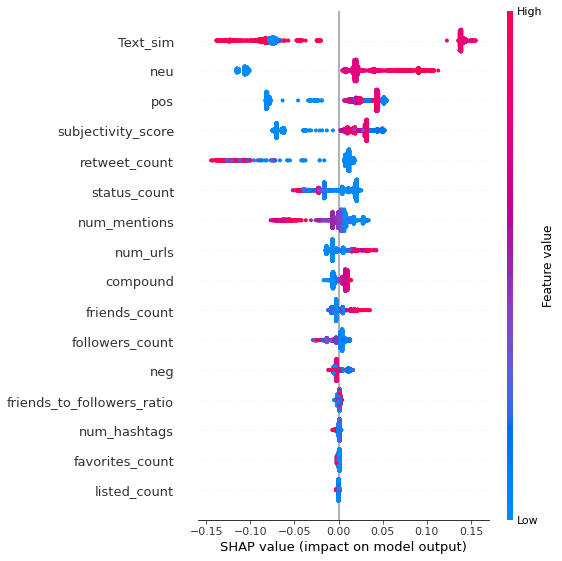

In [ ]:
explainer = shap.TreeExplainer(best_model3,x_test) 
shap_values = explainer.shap_values(x_test) 
shap.summary_plot(shap_values[1],x_test)  #Provide shap model explainer 

In [ ]:
# grid4 = model_selection.GridSearchCV(XGBClassifier(objective ='binary:logistic'),param_grid = xgb_param, scoring='precision_weighted', cv=5)
# grid4.fit(x_train, y_train)
# best_model4 = grid4.best_estimator_
xgb = XGBClassifier(gamma=0.1, max_depth=5, min_child_weight=5, subsample=1.0)
xgb.fit(x_train, y_train)

In [ ]:
explainer = shap.TreeExplainer(best_model4,x_test) 
shap_values = explainer.shap_values(x_test) 
shap.summary_plot(shap_values,x_test) 

In [ ]:
y_pred4 = best_model4.predict(x_test)
clf4 = classification_report(y_pred4, y_test)
print(clf4)

In [ ]:
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred4)) #Print the Matthew Correlation coefficient for Model 4
print('\nf1:',f1_score(y_test, y_pred4)) #Print the F1 score for Model 4
print('\nprecision:',precision_score(y_test, y_pred4)) #Print the Precision for Model 4
print('\nrecall:',recall_score(y_test, y_pred4)) #Print the Recall value for Model 4
print('\nroc:',roc_auc_score(y_test, y_pred4)) #Print the ROC score for Model 4
print('\naccuracy:',accuracy_score(y_test, y_pred4)) #Print the Accuracy  for Model 4


matthews_corrcoef: 0.8663315194656335

f1: 0.9419819819819819

precision: 0.9961890243902439

recall: 0.8933697881066303

roc: 0.9438568397546726

accuracy: 0.9314017895185343


In [ ]:
cf_matrix = confusion_matrix(y_pred4, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt=".0f")

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Human','Bot'])
ax.yaxis.set_ticklabels(['Human','Bot'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
x = pd.concat([x_train,x_test])
y = pd.concat([y_train,y_test])
rf = RandomForestClassifier(n_estimators = 100) #Yang Model

In [ ]:
scoring = {'ACC': 'accuracy', 'recall': 'recall', 'f1': 'f1', 'ROC': 'roc_auc', 'prec': 'precision', 'MCC': make_scorer(matthews_corrcoef)}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=10)
# score1 = cross_validate(best_model3, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score2 = cross_validate(best_model4, x, y, scoring=scoring, cv=cv, return_estimator=True)
score3 = cross_validate(rf, x, y, scoring=scoring, cv=cv, return_estimator=True)

In [ ]:
df = pd.DataFrame(score1)
df.mean()

In [ ]:
df1 = pd.DataFrame(score2)
df1.mean()

In [ ]:
df2 = pd.DataFrame(score3)
df2.mean()